In [58]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [59]:
# read data
df= pd.read_excel("/Users/sophi/Downloads/output.xlsx")

# creates an object of the target variable NEE and an object of independent variables
NEE_column = ['NEE'] 
predictors_columns = list(set(list(df.columns))-set(NEE_column))

# unscaled (standard scaler)
X_unscaled = df[predictors_columns].values
y_unscaled = df[NEE_column].values

# normalizing (Edwin)
df[predictors_columns] = df[predictors_columns]/df[predictors_columns].max()
df.describe().transpose()

# set x and y (Edwin)
X = df[predictors_columns].values
y = df[NEE_column].values


In [60]:
# split data (Edwin)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)

# split data (standard scaler)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_unscaled, y_unscaled, test_size=0.30, random_state=40)


In [61]:
# normalizing (standard scaler)
scaler = StandardScaler()
train_features = scaler.fit_transform(X_train2)
test_features = scaler.transform(X_test2)

In [67]:
# create model (Edwin)
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, y_train)

# create model (standard scaler)
regressor2 = SVR(kernel = 'rbf')
regressor2.fit(train_features, y_train2)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [68]:
# test model (Edwin)
test_set_rsquared = regressor.score(X_test, y_test)
print('Accuracy:',test_set_rsquared)

# test model (standard scaler)
test_set_rsquared2 = regressor2.score(test_features, y_test2)
print('Accuracy:',test_set_rsquared2)


Accuracy: 0.34736024964164613
Accuracy: 0.40706775203822754


Text(0, 0.5, 'NEE Estimated')

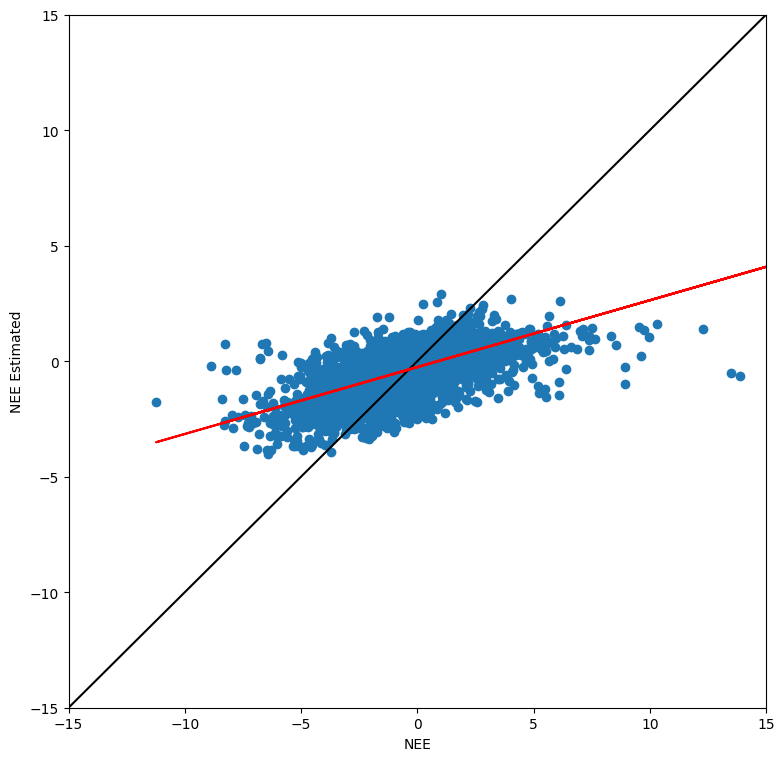

In [69]:
# actual v predicted NEE
predictions = regressor.predict(X_test)
reg = LinearRegression().fit(y_test.reshape((-1, 1)), predictions)
a = reg.coef_
b = reg.intercept_
fig, ax = plt.subplots(1,1,figsize=(9,9))
plt.scatter(y_test, predictions)
plt.plot([-15,15],[-15,15],color = 'k')
plt.plot(y_test, a * y_test + b,color = 'r')
plt.xlim([-15, 15])
plt.ylim([-15, 15])
ax.set_xlabel("NEE")
ax.set_ylabel("NEE Estimated")

In [ ]:
### Feature Importance and Partial Dependence
dff = df.drop('NEE', axis=1).median()
predict_variation = pd.DataFrame(columns = dff.index)
arg = pd.DataFrame(columns = dff.index)
count = 0

for index in dff.index:
    # create variables to store min and max value for "SW_IN"
    minimum, maximum = df[index].min(), df[index].max()

    # create an evenly spaced array of 100 value between min and max
    arr = np.linspace(minimum, maximum, num=100)

    # now create lst of all inputs
    lst = []

    # loop over each variation generated in array
    for variation in arr:
        all_vals = list(df.drop('NEE', axis=1).median().values)
    
        # replace nth variable column with variation
        all_vals[count] = variation
    
        # append variation with ceteris paribus to list of inputs
        lst.append(all_vals)
    
    # transform lst into numpy array to fit model format for evaluation
    lst = np.array(lst)

    arg[index] = arr
    predict_variation[index] = regressor.predict(lst)

    count = count + 1


In [ ]:
impact_dct = {}
keys = dff.index
for index in dff.index:
    impact = abs(predict_variation[index].max() - predict_variation[index].min())
    impact_dct[index] = impact


Text(0.5, 1.0, 'ANN Feature Importance on NEE')

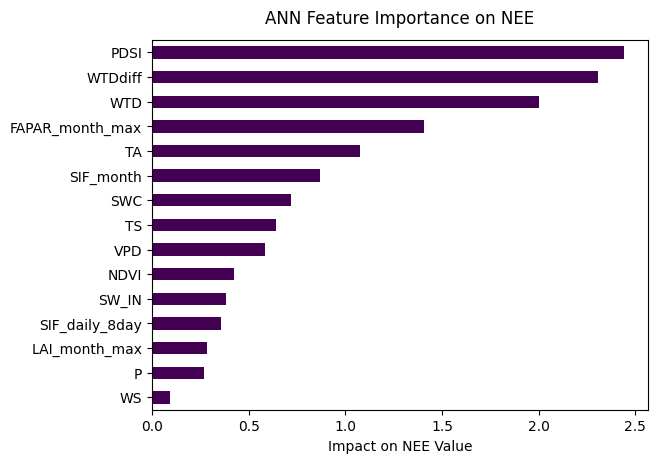

In [ ]:
pd.DataFrame.from_dict(impact_dct, orient='index', columns=['Impact']).sort_values(by="Impact").plot(kind='barh', colormap='viridis')
plt.xlabel("Impact on NEE Value")
plt.legend().remove()
plt.title("ANN Feature Importance on NEE", pad=12)

/var/folders/xr/3dp39yr17rz8vj5ynw6z7vn40000gp/T/ipykernel_15958/939339134.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[index], kde=False, bins=30)


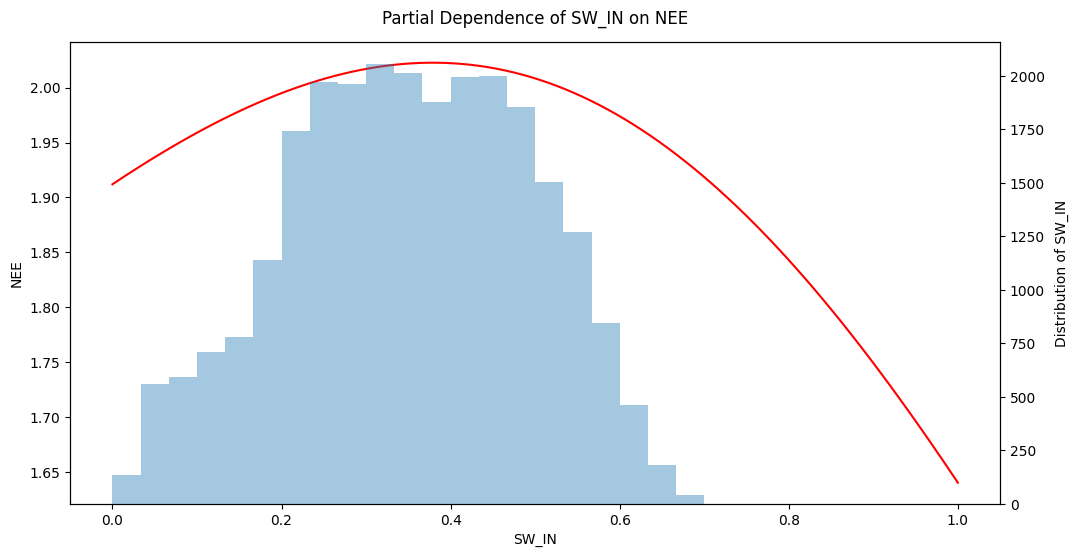

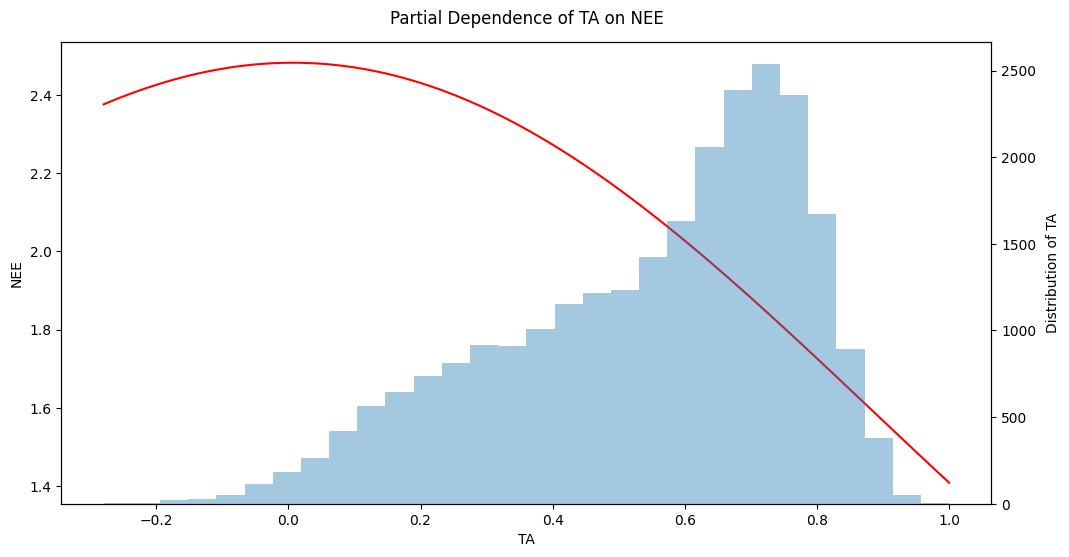

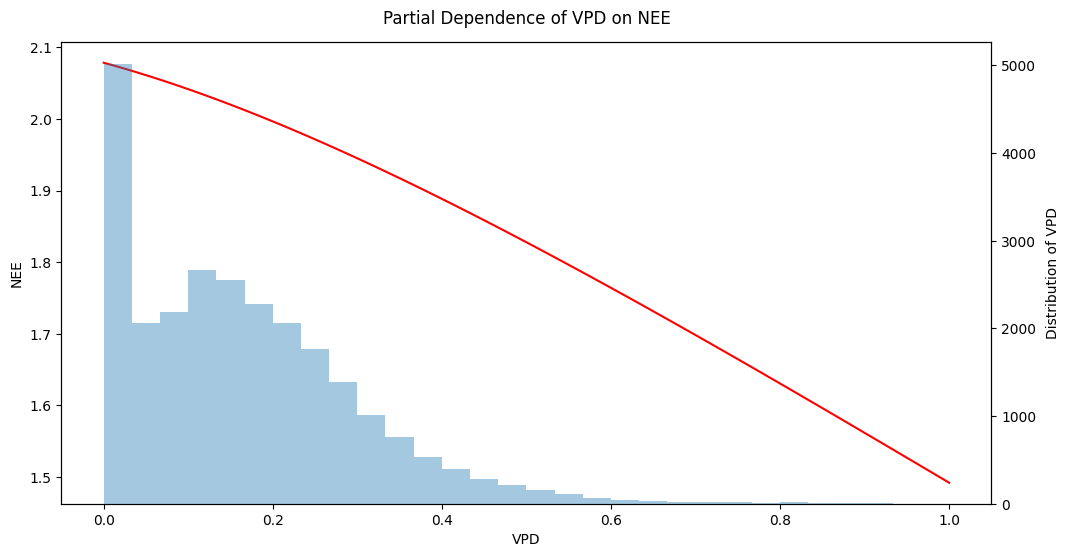

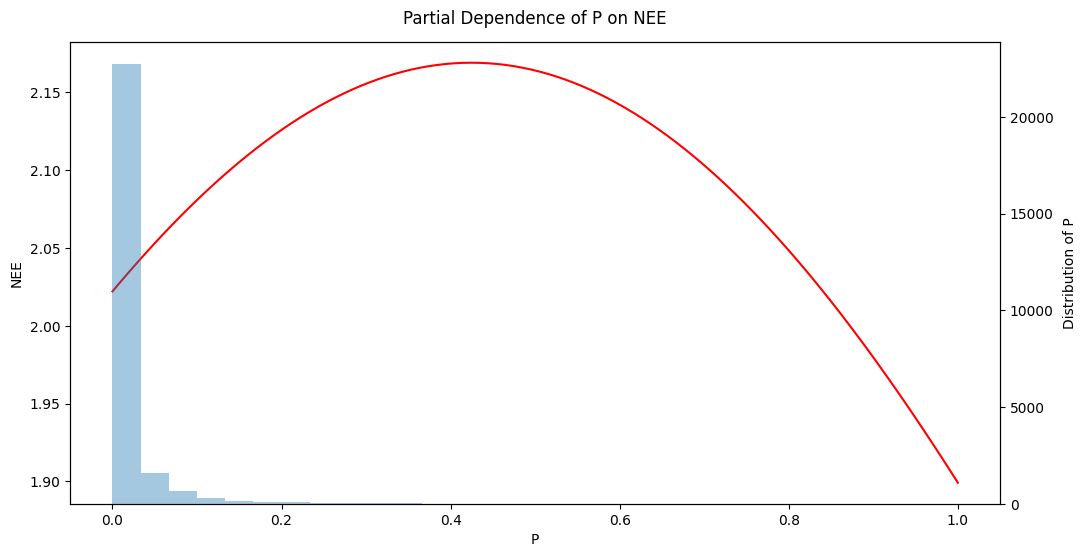

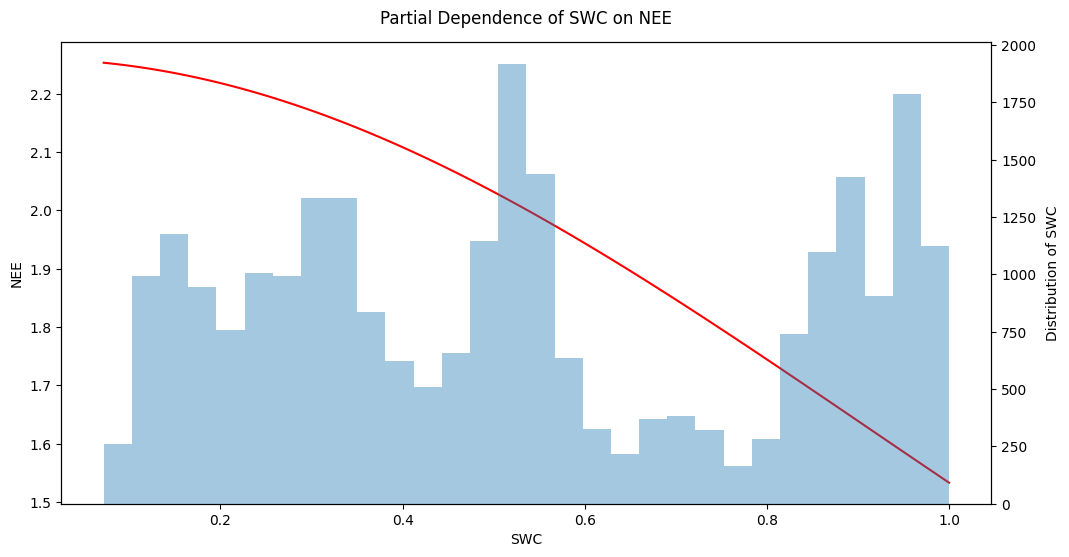

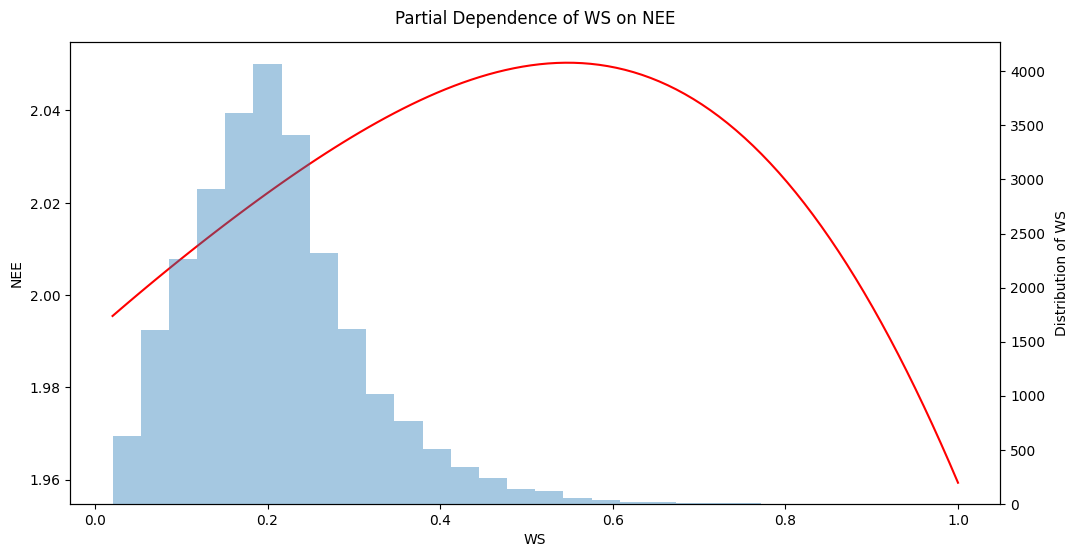

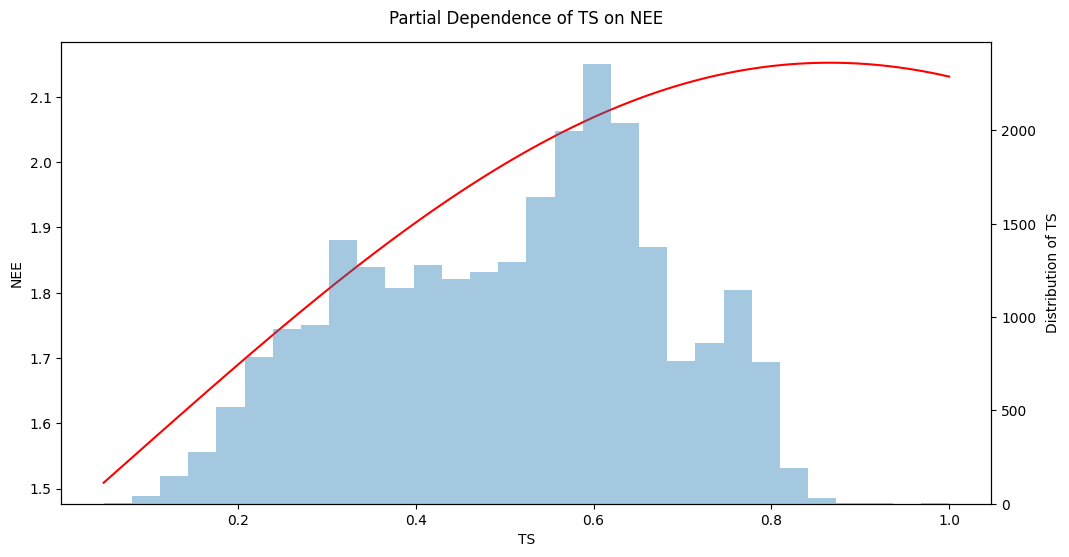

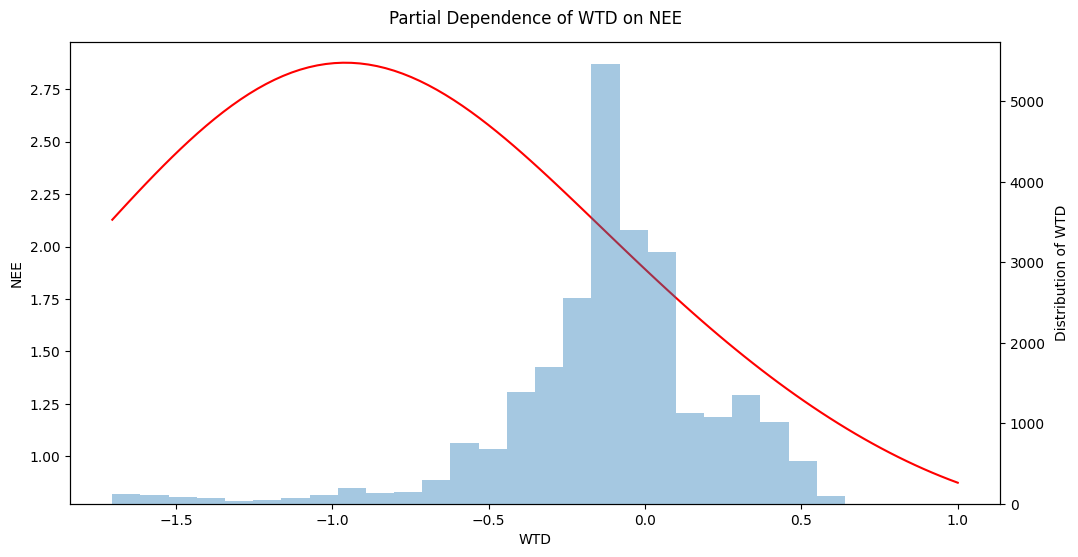

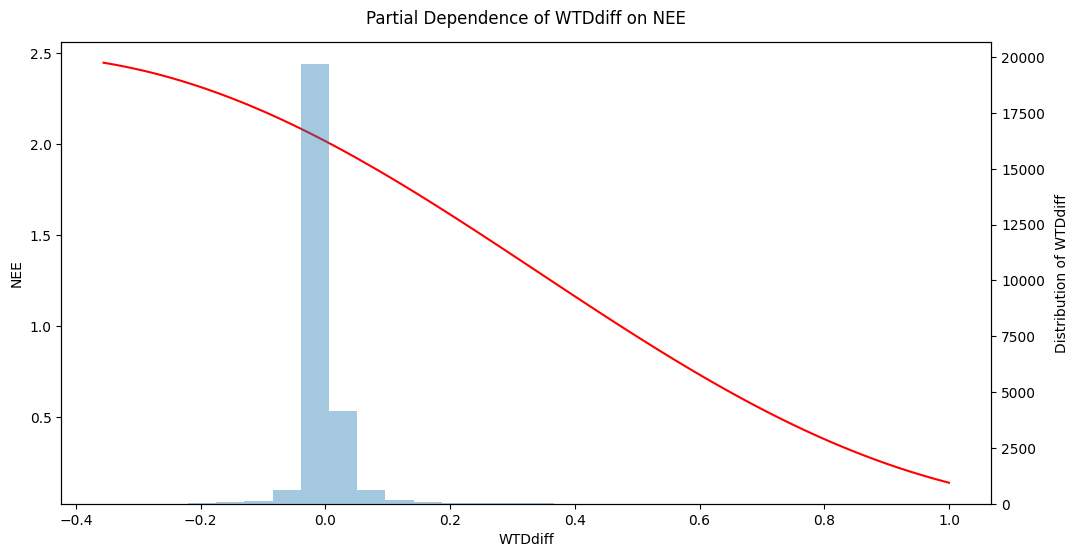

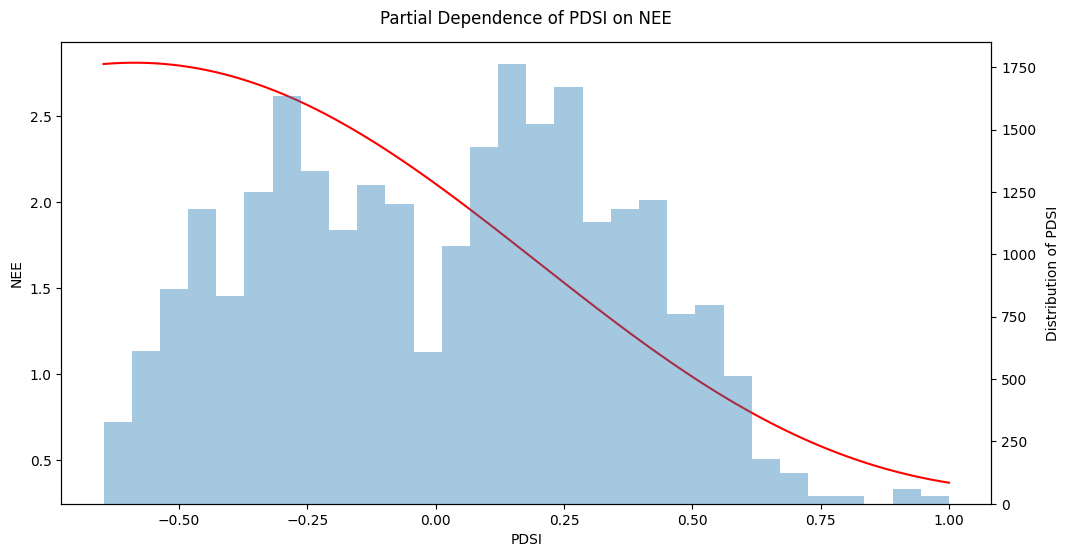

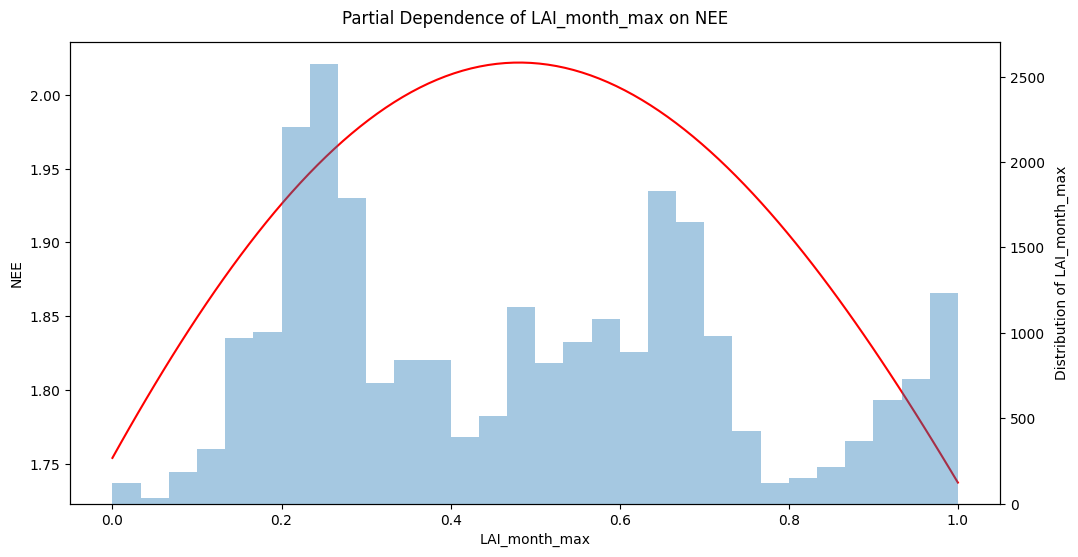

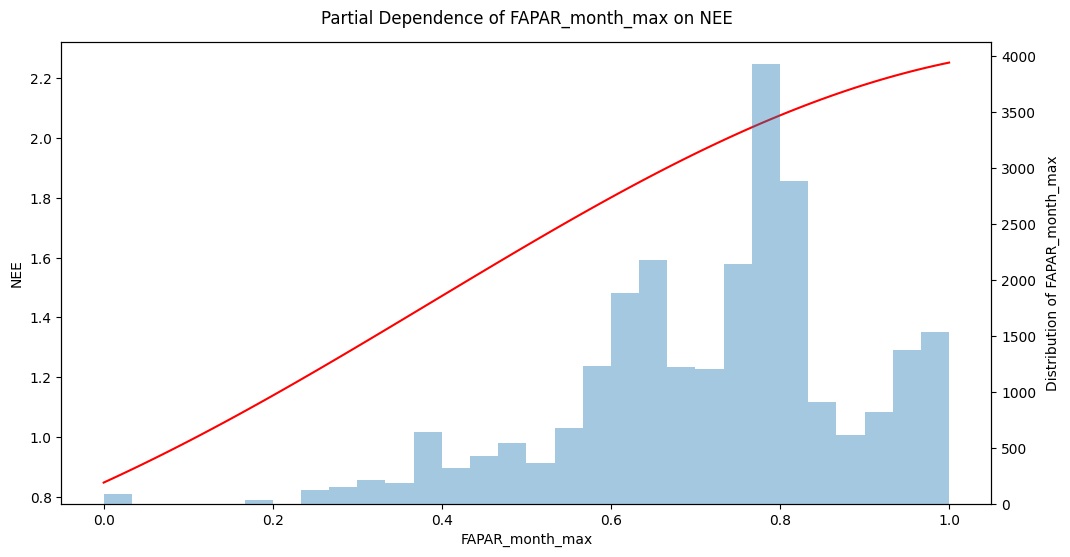

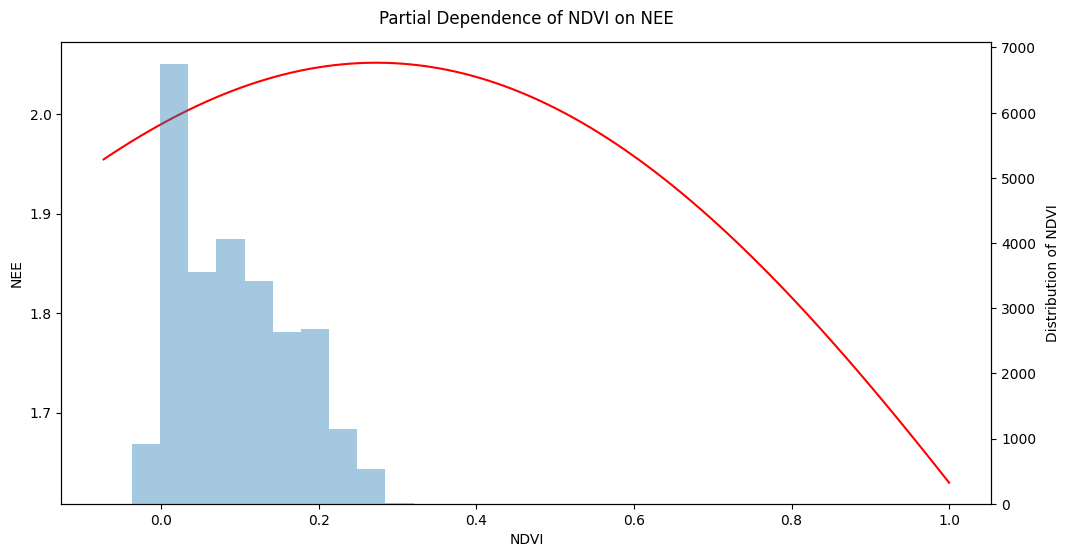

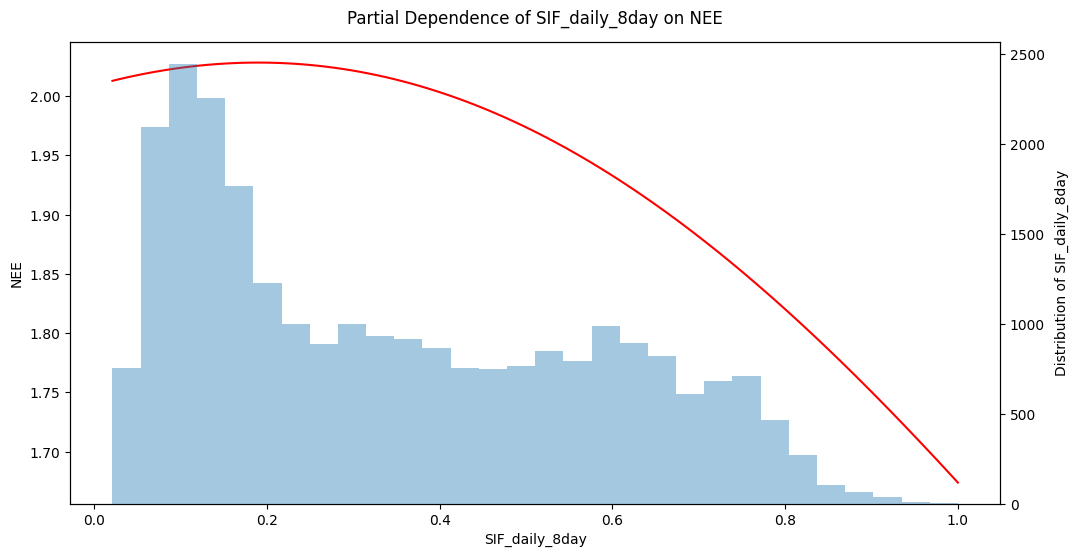

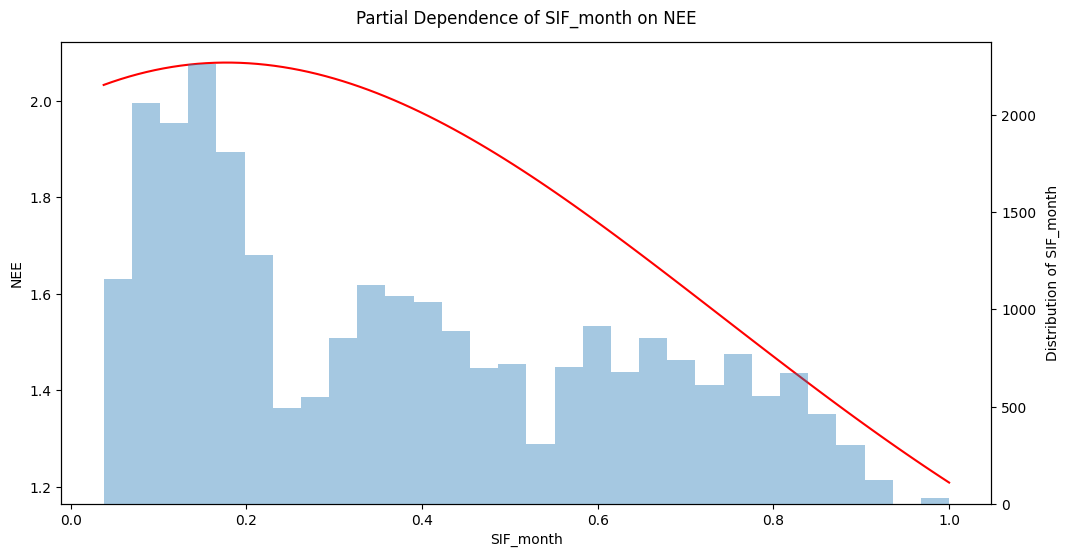

In [ ]:
# Create and display multiple plots in a loop
for index in dff.index:
    plt.figure(figsize=(12, 6))  # Create a new figure for each plot
    plt.plot(arg[index], predict_variation[index], color='r')
    plt.xlabel(index)
    plt.ylabel("NEE")
    plt.twinx()
    sns.distplot(df[index], kde=False, bins=30)
    plt.ylabel(f"Distribution of {index}", labelpad=7)
    plt.title(f"Partial Dependence of {index} on NEE", pad=13)